<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src/CE_Preprocessing_Tranining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [6]:
data_dir = '/content/drive/MyDrive/Research/Crowd Emotion/Spectrograms/Mel/'
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

967


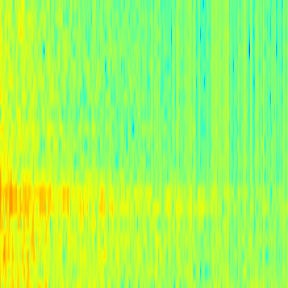

In [9]:
approvals = list(data_dir.glob('Approval/*'))
PIL.Image.open(str(approvals[10]))

In [10]:
batch_size = 32
img_height = 227
img_width = 227

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "training",
    seed                      = 42,
    image_size                = (img_height, img_width),
    batch_size                = batch_size
)

Found 967 files belonging to 3 classes.
Using 774 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory                 = data_dir,
    validation_split          = 0.2,
    subset                    = "validation",
    seed                      = 42,
    image_size                = (img_height, img_width),
    batch_size                = batch_size
)

Found 967 files belonging to 3 classes.
Using 193 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['Approval', 'Disapproval', 'Neutral']


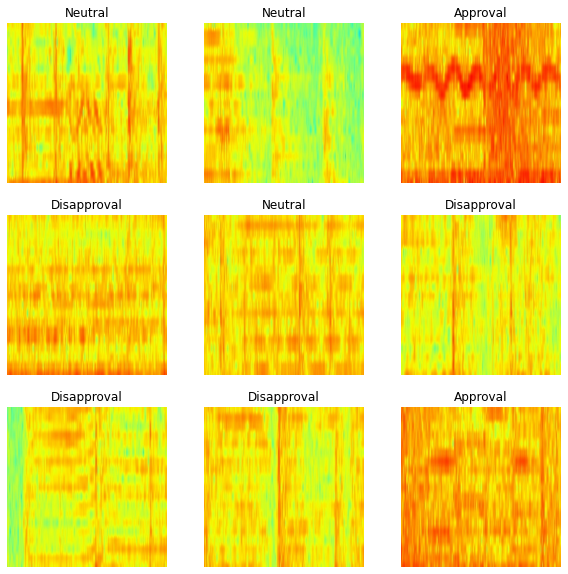

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
num_classes = 3

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
25/25 [==============================] - 200s 8s/step - loss: 1.2813 - accuracy: 0.4014 - val_loss: 1.0901 - val_accuracy: 0.3731
Epoch 2/3
25/25 [==============================] - 1s 35ms/step - loss: 1.0492 - accuracy: 0.4011 - val_loss: 1.0329 - val_accuracy: 0.3938
Epoch 3/3
25/25 [==============================] - 1s 34ms/step - loss: 1.0157 - accuracy: 0.4358 - val_loss: 1.0844 - val_accuracy: 0.3938
